In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df=pd.read_csv("wine-reviews.csv",usecols=['country','description','points','price','variety','winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
df=df.dropna(subset=['description','points'])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


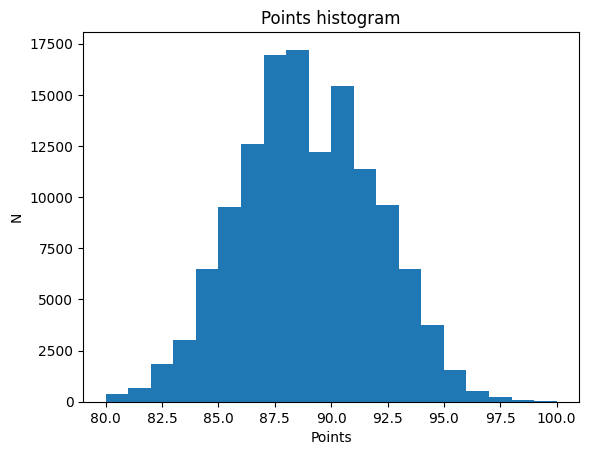

In [5]:
plt.hist(df.points,bins=20)
plt.title('Points histogram')
plt.ylabel('N')
plt.xlabel("Points")
plt.show()

In [6]:
df['label']=(df.points>=90).astype(int)
df=df[['description','label']]

In [7]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])
len(train),len(val),len(test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(103976, 12997, 12998)

In [8]:
def df_to_dataset(dataframe,shuffle=True,batch_size=1024):
  df=dataframe.copy()
  labels=df.pop('label')
  df=df['description']
  ds=tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds=ds.shuffle(buffer_size=len(dataframe))
  ds=ds.batch(batch_size)
  ds=ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [9]:
train_data=df_to_dataset(train)
valid_data=df_to_dataset(val)
test_data=df_to_dataset(test)

In [10]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'This is an attractive wine, dominated by the typical Baga grape from Bairrada. Its tannins are tamed and rounded out producing rich black fruits and fine balanced acidity. The wine is ready to drink, although it will be even better from 2017.',
        b"A pretty good Pinot that, at the equivalent of 10 bucks a bottle, is a nice buy. It's an easy wine, dry, light-bodied and silky, with modest cherry and spice flavors.",
        b'Tight, crisp and mineral driven, this wine has citrus fruits and a steely texture, demonstrating that it needs to age for a year.',
        ...,
        b'Dark-skinned berry, exotic spice, blue flower and wild herb aromas take center stage in this Barolo. Full-bodied and loaded with finesse, the taut, precise palate offers juicy red cherry, cranberry, star anise and clove flavors framed by firm, fine-grained tannins and vibrant acidity. Drink 2023\xe2\x80\x932033.',
        b'Produced by probaby the mo

In [11]:
from tensorflow.keras.layers import Lambda  # Import Lambda layer

# Define the hub_layer correctly
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

# Wrap the hub_layer in a Lambda layer
wrapped_hub_layer = Lambda(lambda x: hub_layer(x))

# Define the model using the wrapped hub layer
model = tf.keras.Sequential([
    wrapped_hub_layer,  # Use the wrapped hub layer
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.26484668, -0.3877812 ,  0.1198285 , ...,  0.10965152,
        -0.09910741,  0.11692306],
       [ 0.4635704 , -0.18628712,  0.07435006, ..., -0.08234034,
        -0.42366734, -0.23155189],
       [ 0.40764585, -0.14307357, -0.0081856 , ..., -0.05004137,
        -0.09397795,  0.00682598],
       ...,
       [ 0.15347707, -0.58863175,  0.01829963, ...,  0.09205195,
        -0.02303446, -0.02630384],
       [ 0.533403  , -0.0661121 ,  0.09265707, ..., -0.17803329,
        -0.08667002,  0.10817976],
       [ 0.28314197,  0.15033703,  0.01926202, ..., -0.13881591,
        -0.00142158,  0.34418786]], dtype=float32)>

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [14]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4126 - loss: 0.7086


[0.7086677551269531, 0.4124220907688141]

In [15]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4217 - loss: 0.7066


[0.7070598602294922, 0.4195583462715149]

In [16]:
history=model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5624 - loss: 0.6848 - val_accuracy: 0.6168 - val_loss: 0.6527
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6328 - loss: 0.6487 - val_accuracy: 0.6501 - val_loss: 0.6255
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6504 - loss: 0.6301 - val_accuracy: 0.6770 - val_loss: 0.6046
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6632 - loss: 0.6146 - val_accuracy: 0.6869 - val_loss: 0.5945
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6715 - loss: 0.6050 - val_accuracy: 0.6895 - val_loss: 0.5878


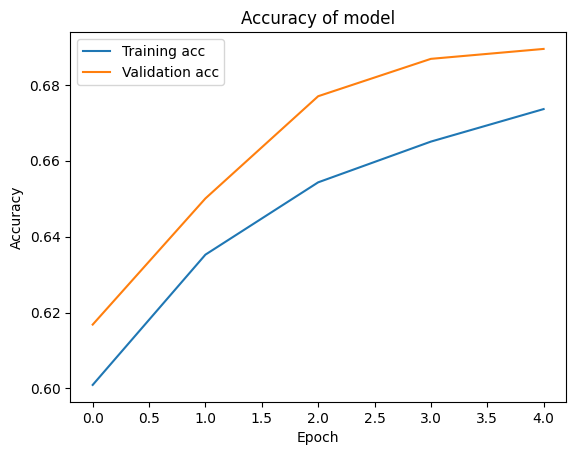

In [19]:
plt.plot(history.history['accuracy'],label='Training acc')
plt.plot(history.history['val_accuracy'],label='Validation acc')
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

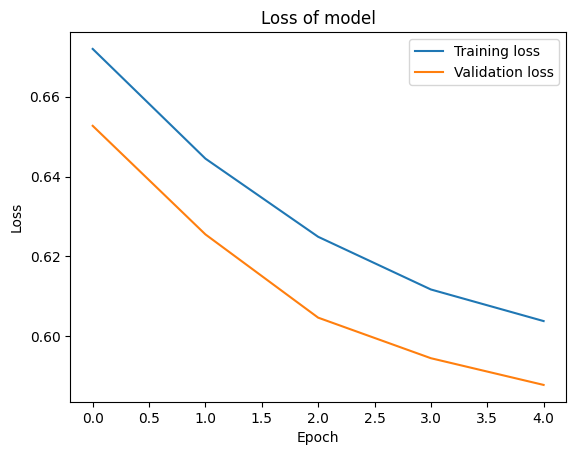

In [20]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [21]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6941 - loss: 0.5854


[0.5861682295799255, 0.6924142241477966]

LSTM

In [22]:
encoder=tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text,label: text))

In [23]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [24]:
model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
model.evaluate(train_data)
model.evaluate(valid_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.5193 - loss: 0.6930
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5174 - loss: 0.6930


[0.6930269002914429, 0.5200430750846863]

In [27]:
history=model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 50s 446ms/step - accuracy: 0.6534 - loss: 0.6233 - val_accuracy: 0.8181 - val_loss: 0.4000
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 429ms/step - accuracy: 0.8327 - loss: 0.3761 - val_accuracy: 0.8358 - val_loss: 0.3634
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 425ms/step - accuracy: 0.8433 - loss: 0.3520 - val_accuracy: 0.8393 - val_loss: 0.3492
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 419ms/step - accuracy: 0.8488 - loss: 0.3414 - val_accuracy: 0.8394 - val_loss: 0.3490
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 84s 435ms/step - accuracy: 0.8511 - loss: 0.3382 - val_accuracy: 0.8410 - val_loss: 0.3465


In [28]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8367 - loss: 0.3498


[0.3471972346305847, 0.8376673460006714]